In [1]:
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"

import numpy as np
from sort_src.sort import SORT
from sort_src.sort_utils import get_dist
from sort_src.fold_utils import get_all_metrics, filter_dbr_by_dist, plot_structure, get_coords
from cmap import Colormap
import matplotlib.pyplot as plt
from scipy.stats import norm, pearsonr, mannwhitneyu
import pickle
from sort_src.pydscatter import dscatter_plot
from scipy.cluster.hierarchy import dendrogram, fcluster

# Randomized library: identification of sequences by clustering

The following `bash` code merges FASTQ files for Sort-seq sequencing data, then finds and counts all uniquely occurring sequences:

```bash
output_dir="temp_outputs"
mkdir -p "$output_dir"

seqtk seq -A fastq/random_input_fp.fastq.gz | gzip > ${output_dir}/random_input.fasta.gz && echo "Processed input."

# Process bin files in parallel using GNU parallel
for i in {1..16}; do
  input_file=$(printf "fastq/random_bin%02d_fp.fastq.gz" "$i")
  if [ -f "$input_file" ]; then
    echo "$input_file"
  else
    echo "$input_file does not exist, skipping." >&2  # Send the error message to stderr
  fi
done | parallel -j 16 'base_name=$(basename {.}); seqtk seq -A {} | gzip > '"${output_dir}"'/${base_name}.fasta.gz && echo Processed {}'

# Combine all individual outputs into the final file
echo "merging files..."
cat ${output_dir}/*.fasta.gz > ./random_input.fasta.gz
echo "done."

# separate out sequences only
echo "filtering sequences only..."
seqkit fx2tab random_input.fasta.gz | awk '{print $4}' > temp_sequences.txt

# sort the sequences
echo "sorting..."
# Split the input file into smaller chunks
split -l 5000000 -a 4 --additional-suffix=.txt temp_sequences.txt part_
# Sort each chunk in parallel
ls part_*.txt | parallel -j 16 'sort -S 8G {} -o {}.sorted'
# Merge the sorted files into one sorted output file
echo "merging..."
sort -m -S 128G -o temp_sequences_sorted.txt part_*.sorted
# Remove sorted part files after merging
rm part_*.sorted
rm part_*.txt

# counting how often every sequence occurs
echo "counting..."
uniq -c temp_sequences_sorted.txt > counts.txt
echo "finished."
```

Next, sequences are filtered by thresholding based on counts.

```python
counts = np.array(pd.read_csv('counts.txt', header=None, delimiter='\s', engine='python')[0])
seqs   = np.array(pd.read_csv('counts.txt', header=None, delimiter='\s', engine='python')[1])
cutoff = 20

x = np.arange(5, 1001, 1)

n_vars = []
for co in x:
    n_vars.append(np.sum(counts>co))

plt.plot(x, n_vars, '-')
plt.plot([cutoff, cutoff], [0, np.sum(counts>=cutoff)], '--r')
plt.title(f"{np.sum(counts>=cutoff)} variants found.")
plt.show()

seqs_selected = [seq[20:-20] for seq in seqs[counts>=cutoff]]

# export to fasta
with open('random_lib.fasta', 'w') as f:
    for i, seq in enumerate(seqs_selected):
        f.write(f">{i}\n")
        f.write(f"{seq}\n")
```

Next, thresholded sequences are clustered using the `clusterize` package in `R`:

```R
# clustering using the DECIPHER package
library(DECIPHER)
dna <- readDNAStringSet('random_lib.fasta')
thresholds <- seq(0.4, 0.1, by = -0.01)
clusters <- Clusterize(dna, cutoff=thresholds, penalizeGapLetterMatches=TRUE, method="shortest", minCoverage=0, includeTerminalGaps=TRUE, processors=6)
for (i in 1:length(thresholds)) {
  file_path <- paste0("clusters_", sprintf("%.3f", thresholds[i]), ".csv")
  write.csv(clusters[[i]], file_path)
}
```

Clusters are loaded and a sensible threshold is chosen; the final fasta file is saved:

```python

def load_fasta(fasta_file):
    variants = {}
    for i in SeqIO.parse(fasta_file, 'fasta'):
        variants[i.id] = str(i.seq)
    return(variants)

def consensus(sequences):
    # Convert the list of sequences into a numpy array where each row is a sequence and each column is a position
    array = np.array([list(seq) for seq in sequences])
    # Find the consensus by getting the most common character at each position
    consensus_seq = ''.join(Counter(array[:, i]).most_common(1)[0][0] for i in range(array.shape[1]))
    return(consensus_seq)

cl_cutoffs = np.arange(0.1, 0.4, 0.01)

n_non_unique = []
seq_df = pd.DataFrame.from_dict(load_fasta('random_lib.fasta'), orient='index').rename(columns={0: 'sequence'})
seq_df['index'] = np.arange(1, len(seqs_selected)+1, 1, dtype=int)
for cutoff in cl_cutoffs:
    clusters = pd.read_csv(f"clusters_{cutoff:.3f}.csv", names=['index', f"{cutoff:.3f}"], header=None, skiprows=1)
    seq_df = seq_df.merge(clusters, on='index')
    n_non_unique.append(len(clusters) - len(np.unique(clusters[f"{cutoff:.3f}"])))

plt.figure(figsize=[3,2])
plt.plot(cl_cutoffs, n_non_unique, 'o-')
plt.xlabel('similarity cutoff')
plt.ylabel('number of sequences in clusters')
plt.yscale('log')
plt.show()

# merge sequences in clusters
chosen_cutoff = '0.150'

cluster_counts = seq_df[chosen_cutoff].value_counts()
real_clusters = cluster_counts[cluster_counts > 1]

print(f"{len(real_clusters)} clusters identified.")

# Filter seq_df to keep only rows where the cluster ID is not in real_clusters
filtered_seqs = list(seq_df['sequence'][~seq_df[chosen_cutoff].isin(real_clusters.index)])

# add back the clusters, calculating the consensus for each
n_2 = 0
for cl, n in real_clusters.items():
    cl_seqs = list(seq_df[seq_df[chosen_cutoff]==cl]['sequence'])
    filtered_seqs.append(consensus(cl_seqs))
    if n == 2:
        n_2 += 1

print(f"{len(seq_df) - len(filtered_seqs)} sequences removed after collapsing clusters.")
print(f"{n_2} clusters had only 2 members (of which one was chosen).")
print(f"{len(filtered_seqs)} sequence variants found in total.")

# sort the sequences
filtered_seqs.sort()

# save the clustered sequences as the reference fasta
with open('../config/fasta_files/random_lib_clust.fasta', 'w') as f:
    for i, seq in enumerate(filtered_seqs):
        f.write(f">{i}\n")
        f.write(f"{seq}\n")
```

This fasta file is used to count variants in the regular Sort-seq data processing pipeline.

## Figure 2a

In [ ]:
# load Sort-seq element from configuration csv specifying all file paths
ran = SORT('../config/sortseq_csvs/random.csv', '../config/fasta_files/random_lib_clust.fasta')
ran.load_flow_data(plot=False)

# in this particular case, adding additional Sort-seq bins that were sorted separately (this is needed because they have their own control measurements)
ran.add_sort_data('../data/fcs/random/random_bin15.fcs', 
                  '../data/fcs/random/random_wt_pos_bin15_bin16.fcs',
                  '../data/fcs/random/random_wt_neg_bin15_bin16.fcs', 
                  '../data/counts/random_bin15_counts.pkl', 
                  'bin_15')

ran.add_sort_data('../data/fcs/random/random_bin16.fcs', 
                  '../data/fcs/random/random_wt_pos_bin15_bin16.fcs',
                  '../data/fcs/random/random_wt_neg_bin15_bin16.fcs', 
                  '../data/counts/random_bin16_counts.pkl', 
                  'bin_16')

# load counts data and infer fluorescence (depending on CPUs available,  this step of running MLE for every variant takes a bit)
# On 8 Apple Silicon cores it takes ~6min
ran.load_seq_data(min_reads=0, cutoff=0.001, n_cpu=8)

# remove variants found in only one bin (because less accurate)
min_bin = 2
multi_bin = (np.sum(ran.sort_mat > 0, axis=1) >= min_bin) & np.all(np.isfinite(ran.sort_mat), axis=1)
ran.sort_mat = ran.sort_mat[multi_bin]
ran.sort_df  = ran.sort_df.filter(multi_bin)

# find and remove sequences that have altered constant parts
non_can = []
for idx, seq in enumerate(list(ran.sort_df['index'])):
    if not seq[:6] == 'GTATGT' or not seq[-36:] == 'TTACTAACAGGGTATTTTGCTACTACCATCAAATAG':
        non_can.append(idx)
non_can_mask = np.ones(len(ran.sort_df)).astype(bool)
non_can_mask[non_can] = False

ran.sort_mat = ran.sort_mat[non_can_mask]
ran.sort_df  = ran.sort_df.filter(non_can_mask)

print(f"{len(ran.sort_df)} variants passed filters.")

/Users/leo/Documents/repos/intron_sortseq/sort_src/sort_utils.py:18: RuntimeWarning: invalid value encountered in divide
  sort_mat_scaled = sort_mat_scaled/np.sum(sort_mat_scaled, axis=1)[:,None]


90064 variants passed filters.


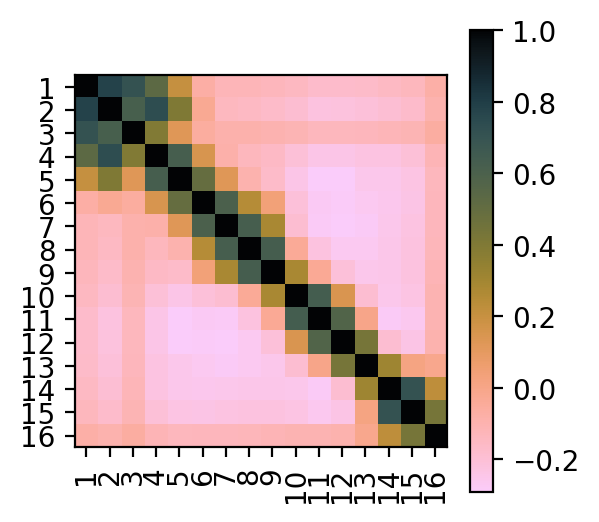

In [8]:
# plot individual bin distributions
fig, axs = plt.subplots(figsize=[3, 3])
corr_mat = get_dist(ran.sort_mat)
cmap_r = Colormap('batlowk_r').to_mpl()
im = axs.imshow(corr_mat, cmap=cmap_r)
cbar = fig.colorbar(im, ax=axs)
axs.set_xticks(np.arange(0, 16, 1))
axs.set_xticklabels(np.arange(1, 17, 1), rotation=90)
axs.set_yticks(np.arange(0, 16, 1))
axs.set_yticklabels(np.arange(1, 17, 1))

plt.show()

/var/folders/6n/fclyr6_j77n3zhrfxszt4fp00000gn/T/ipykernel_9380/1084561855.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  y_fit *= max(y) / max(y_fit)  # Scale the fit to match histogram heights
/var/folders/6n/fclyr6_j77n3zhrfxszt4fp00000gn/T/ipykernel_9380/1084561855.py:7: RuntimeWarning: invalid value encountered in multiply
  y_fit *= max(y) / max(y_fit)  # Scale the fit to match histogram heights


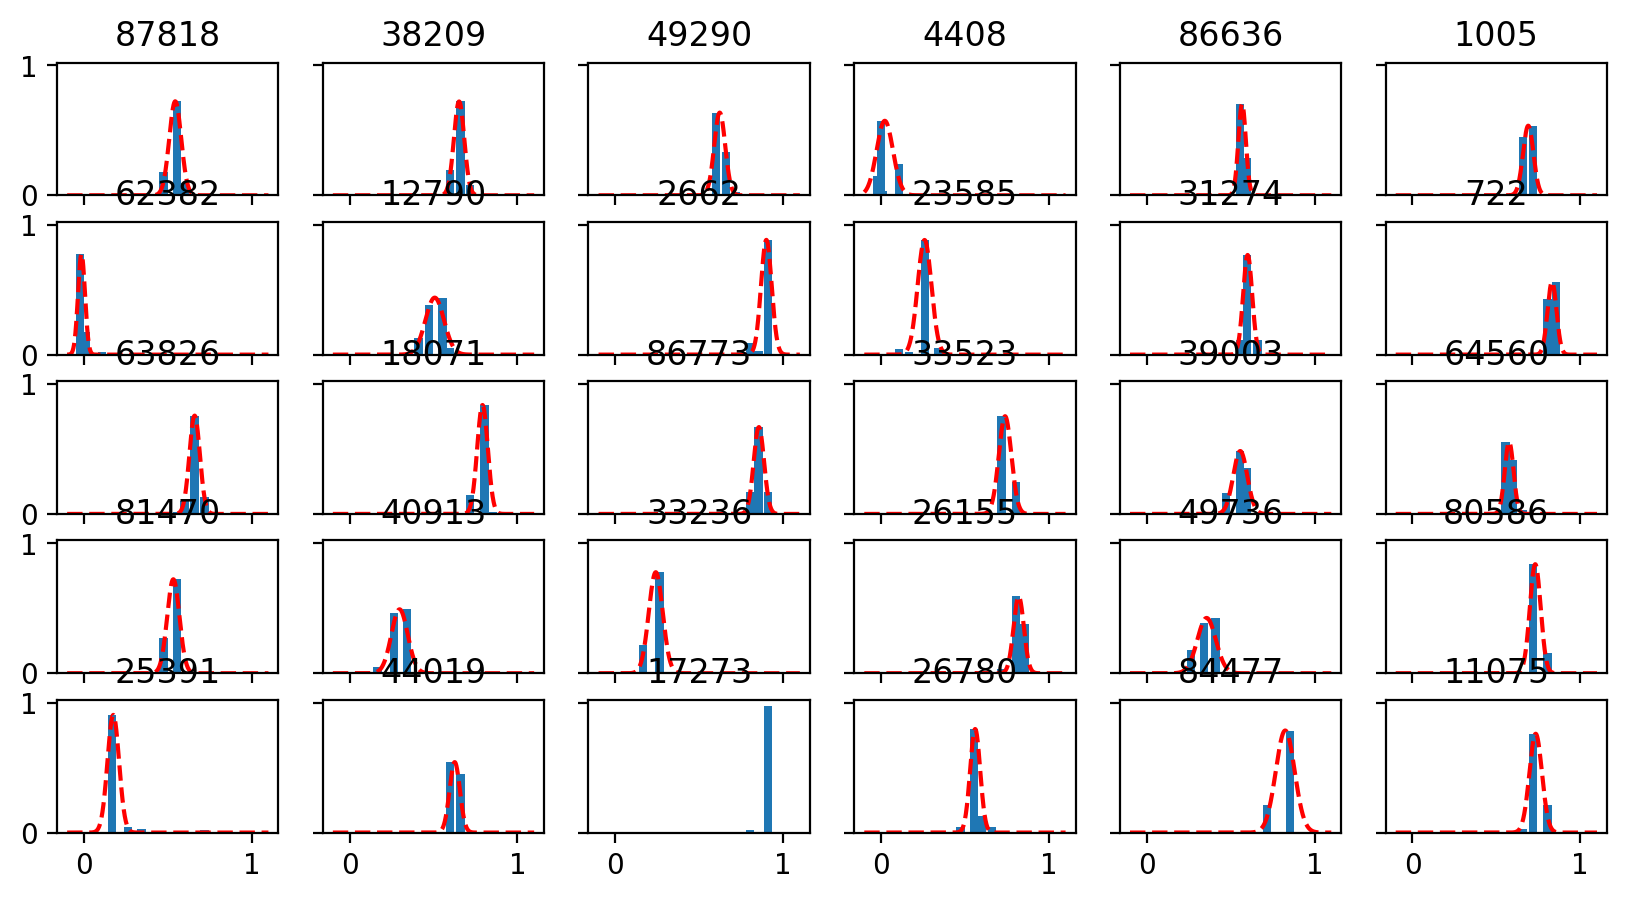

In [9]:
def random_vars_grid(lib):

    def plot_mle(y, mu, si, axs, cstr):
        # Plot the fitted normal distribution
        x_fit = np.linspace(-0.1, 1.1, 1000)
        y_fit = norm.pdf(x_fit, mu, si)
        y_fit *= max(y) / max(y_fit)  # Scale the fit to match histogram heights
        axs.plot(x_fit, y_fit, cstr)

    fig, axs = plt.subplots(5, 6, figsize=[10, 5], sharex=True, sharey=True)
    axs = axs.flatten()

    rnd_idx = np.random.choice(list(range(len(lib.sort_df))), size=30, replace=False).tolist()
    for i, idx in enumerate(rnd_idx):
        
        axs[i].bar([lib.bin_medians[i] for i in lib.order], lib.sort_mat[idx,:], 0.05)
        axs[i].set_title(idx)
        plot_mle(lib.sort_mat[idx,:], lib.sort_df['mu_est'][idx], lib.sort_df['si_est'][idx], axs[i], '--r')

    plt.show()

random_vars_grid(ran)

The following code block calculates the optimal RNA structure prediction window. This is resource-intensive, so instead you can just load the pre-combuted matrix that is supplied here.

```python
def random_mask(n, frac, seed=42):
    random.seed(seed)
    n_true = round(frac*n)
    msk = [True]*n_true + [False]*(n-n_true)
    random.shuffle(msk)
    return(np.array(msk))

def run():

    e1 = 'UUAGUUUCGAAUAAACACACAUAAACAAACAAAUCUAGAAUGUACCCAUACGAUGUUCCUGACUAUGCUGGUUCUGCAG'
    e2 = 'GUGUCUCUAAGGGUGAAGAAGAUAACAUGGCUUCUUUGCCAGCCACCCACGAGUUGCACAUCUUCGGUUCCAUUAACGG'

    a_msk = np.array([seq[6] == 'A' for seq in list(ran.sort_df['index'])])

    # rfr scan
    y = np.array(ran.sort_df['mu_est'])[a_msk]
    s = np.array(ran.sort_df['index'])[a_msk]

    ####################################################
    n_cpu = 64
    step_size = 1
    e1_dist = np.arange(1, len(e1) + step_size, step_size)
    step_size = 2
    i1_dist = np.arange(1, len(s[0]+e2) + step_size, step_size)
    ####################################################

    score_mat = np.zeros((len(e1_dist), len(i1_dist)))
    corr_mat = np.zeros((len(e1_dist), len(i1_dist)))
    for i, j in tqdm(itertools.product(np.arange(len(e1_dist)), np.arange(len(i1_dist))), total=len(e1_dist)*len(i1_dist)):
        
        # structure prediction
        pred_seqs = [e1[-e1_dist[i]:] + (intron+e2)[:i1_dist[j]] for intron in s]
        bpp, dbr_mea, mea, dbr_mfe, mfe, dbr_efe, efe, p_mfe, ent, ed = get_all_metrics(pred_seqs, n_cpu=n_cpu)
        corr  = pearsonr(efe, y).statistic
        corr_mat[i, j]  = corr

    return(corr_mat)
            
corr_mat = run()
```

In [6]:
# load structure prediction scan
with open('../data/miscellaneous/random_corr_scan.pkl', 'rb') as f:
    corr_mat = pickle.load(f)

e1 = 'UUAGUUUCGAAUAAACACACAUAAACAAACAAAUCUAGAAUGUACCCAUACGAUGUUCCUGACUAUGCUGGUUCUGCAG'
e2 = 'GUGUCUCUAAGGGUGAAGAAGAUAACAUGGCUUCUUUGCCAGCCACCCACGAGUUGCACAUCUUCGGUUCCAUUAACGG'
step_size = 1
e1_dist = np.arange(1, len(e1) + step_size, step_size)
step_size = 2
i1_dist = np.arange(1, len(ran.sort_df['index'][0]+e2) + step_size, step_size)

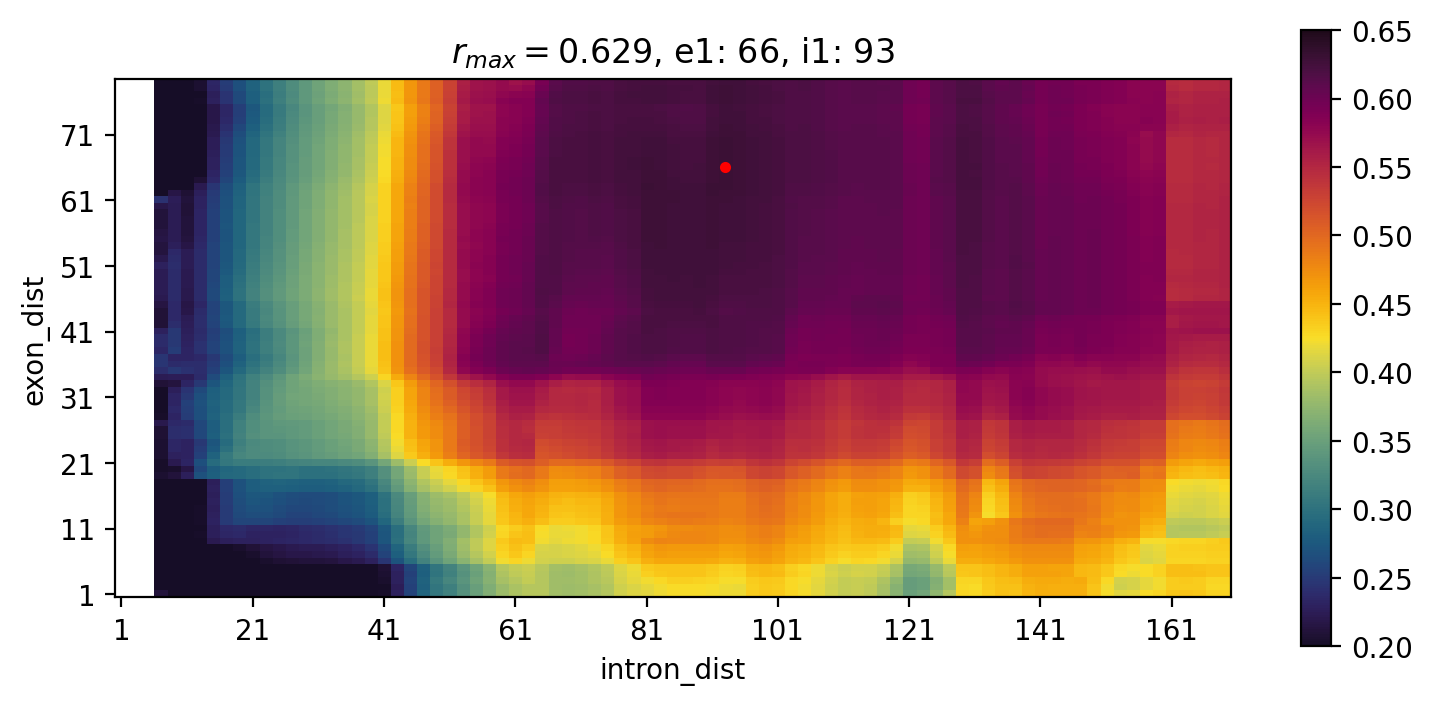

In [7]:
fig, axs = plt.subplots(figsize=[9, 4], sharey=True)
pride = Colormap('pride').to_mpl()
c = axs.imshow(corr_mat, vmin=0.2, vmax=0.65, cmap=pride, origin='lower', aspect=0.5)
best_pos = np.unravel_index(np.nanargmax(corr_mat), corr_mat.shape)
axs.plot(best_pos[1], best_pos[0], '.r')
axs.set_title(f"$r_{{max}}=${np.nanmax(corr_mat):.3f}, e1: {e1_dist[best_pos[0]]}, i1: {i1_dist[best_pos[1]]}")

axs.set_yticks(np.arange(0, corr_mat.shape[0], 10), [e1_dist[i] for i in np.arange(0, corr_mat.shape[0], 10)])
axs.set_xticks(np.arange(0, corr_mat.shape[1], 10), [i1_dist[i] for i in np.arange(0, corr_mat.shape[1], 10)])

axs.set_xlabel('intron_dist')
axs.set_ylabel('exon_dist')
plt.colorbar(c)
plt.show()

## Figure 2b

In [ ]:
# do the structure prediction with optimal window
# This might take a while depending on how many CPUs you have available. On 8 Apple Silicon cores it takes ~20min
pred_seqs = [e1[-e1_dist[best_pos[0]]:] + (intron+e2)[:i1_dist[best_pos[1]]] for intron in ran.sort_df['index']]
bpp, dbr_mea, mea, dbr_mfe, mfe, dbr_efe, efe, p_mfe, ent, ed = get_all_metrics(pred_seqs, n_cpu=8, temp=30.0)

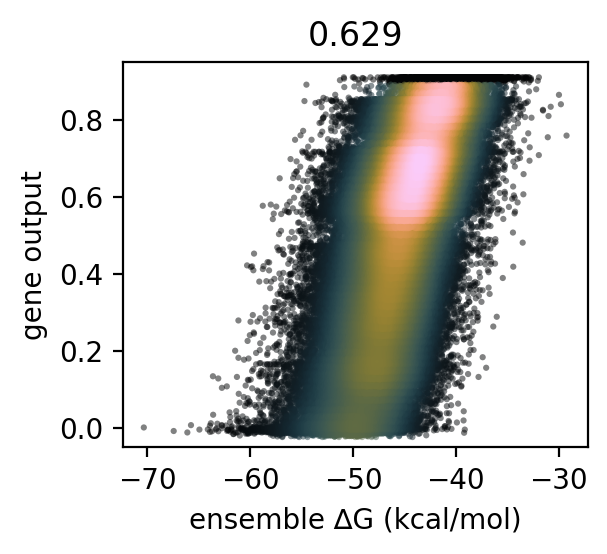

In [50]:
# gene output versus ensemble free energy
cmap_f = Colormap('batlowk').to_mpl()
fig, axs = plt.subplots(figsize=[3,2.5])
dscatter_plot(efe, ran.sort_df['mu_est'], log=[False, False], alpha=0.5, edgecolors='none', nbins=[400,50], lamb=16, cmap=cmap_f, order=True, rasterized=True)
plt.title(f"{pearsonr(efe, ran.sort_df['mu_est'])[0]:.3f}")
plt.xlabel('ensemble ∆G (kcal/mol)')
plt.ylabel('gene output')
plt.ylim(-0.05, 0.95)
plt.show()

## Figure 2c

This block of code runs t-SNE and hierarchical clustering. It is resource intensive, so the pre-computed coordinates and clusters are provided below.

```Python
# do hierarchical clustering
clust = linkage(bpp, method='ward', metric="euclidean", optimal_ordering=False)

# get t-SNE coordinates
tsne = TSNE(n_components=2, random_state=42, perplexity=50, learning_rate=200, n_iter=6000, verbose=1, n_jobs=64)
X_tsne_ent = tsne.fit_transform(ent)
```

In [51]:
# load pre-computed t-SNE coordinates and clusters
with open('../data/miscellaneous/random_hierarch.pkl', 'rb') as f:
    clust = pickle.load(f)
with open('../data/miscellaneous/random_tSNE.pkl', 'rb') as f:
    _, X_tsne_ent = pickle.load(f)

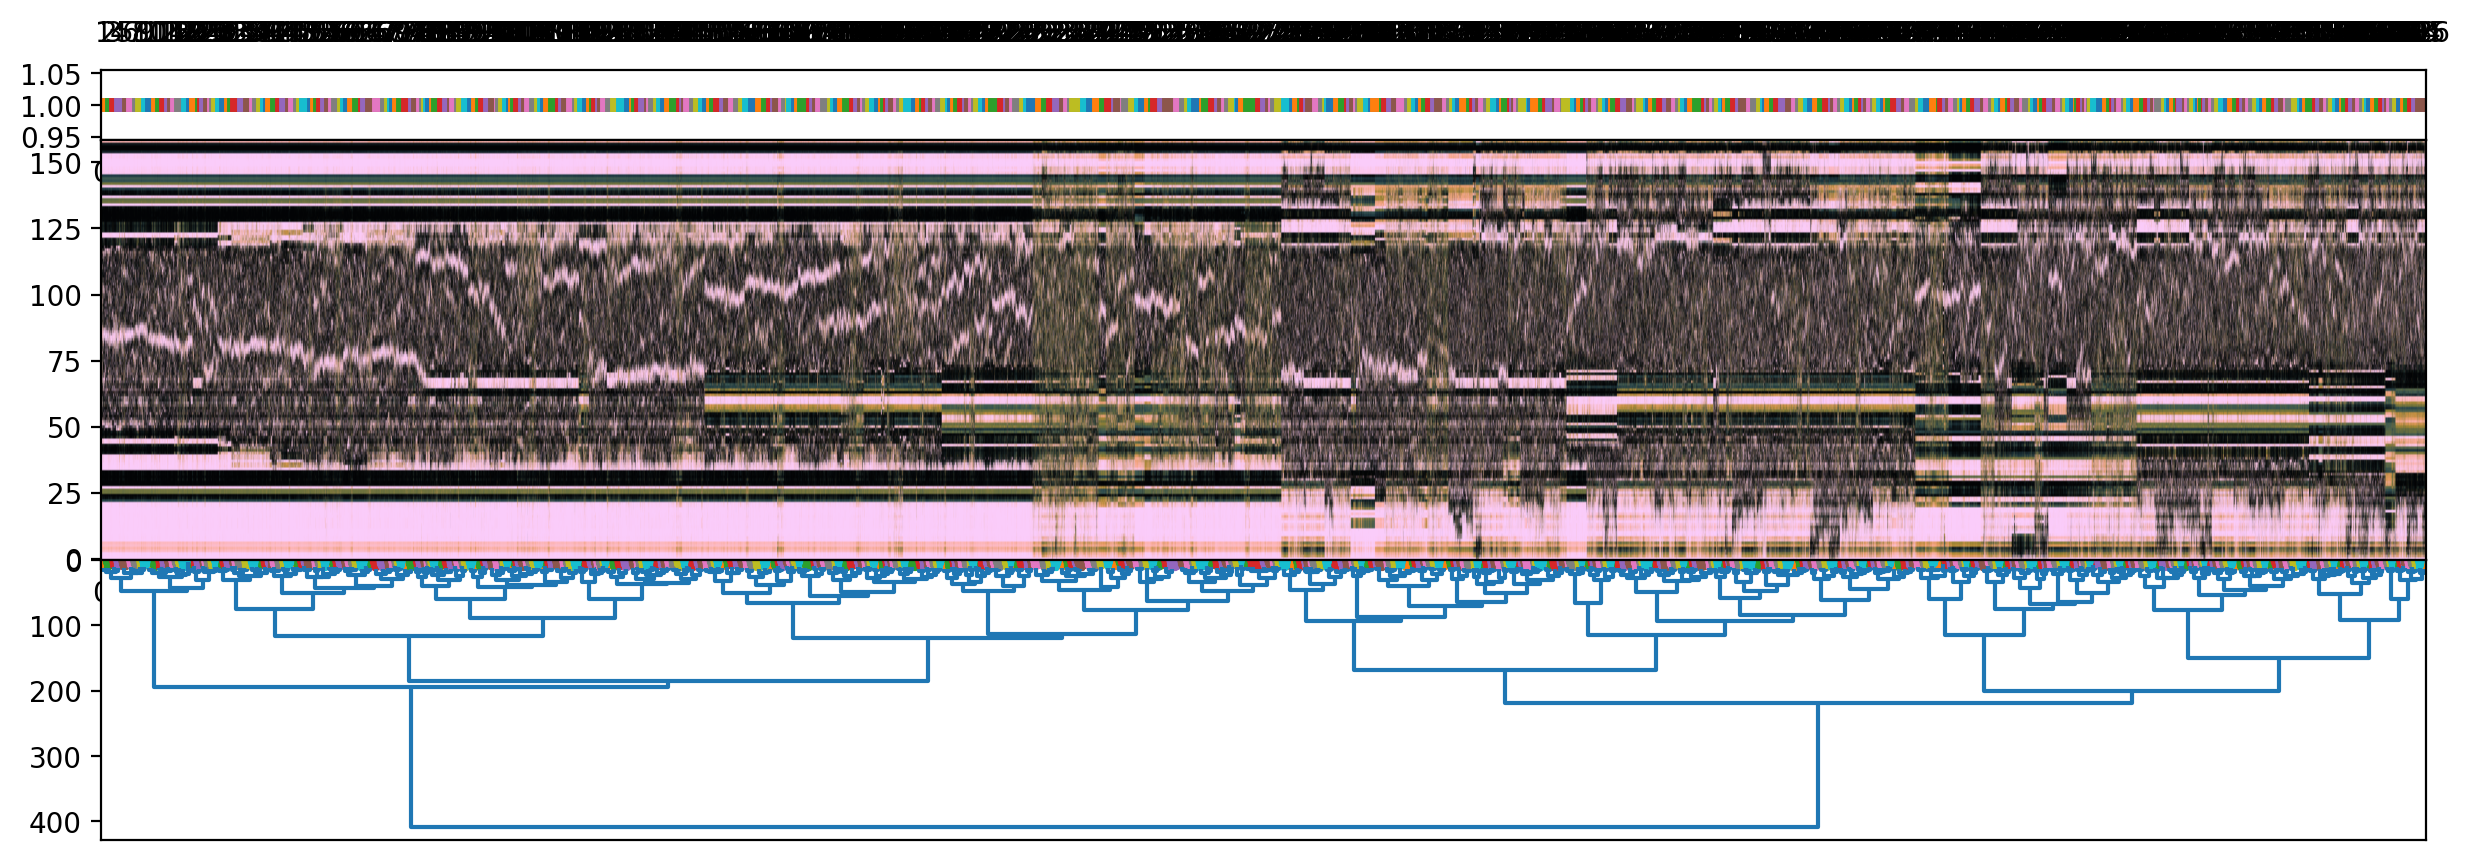

In [53]:
trim = 14

fig, axs = plt.subplots(3, 1, figsize=(15, 5), gridspec_kw={'height_ratios': [1, 6, 4]})
plt.subplots_adjust(hspace=0)
cmap = Colormap('batlowk_r').to_mpl()

# draw dendrogram, retreive class labels for two levels of trimming
leaves = dendrogram(clust, orientation='bottom', color_threshold=trim, no_labels=True, ax=axs[2])
labels = fcluster(clust, trim, criterion='distance')
labels_sort = np.array([labels[i] for i in leaves['leaves']])

# sort
all_probs_sort = np.array([bpp[i] for i in leaves['leaves']])

# draw class assignment
for label in np.unique(labels_sort):
    axs[0].plot(np.argwhere(labels_sort==label), np.sum(labels_sort==label)*[1], lw=5)
    axs[0].text(np.mean(np.argwhere(labels_sort==label)), 1.1, str(label), horizontalalignment='center')

# draw matrix
axs[1].imshow(np.array(all_probs_sort).T, aspect='auto', cmap=cmap, vmin=0.1, vmax=0.9)
axs[1].invert_yaxis()
axs[1].sharex(axs[0])

plt.show()

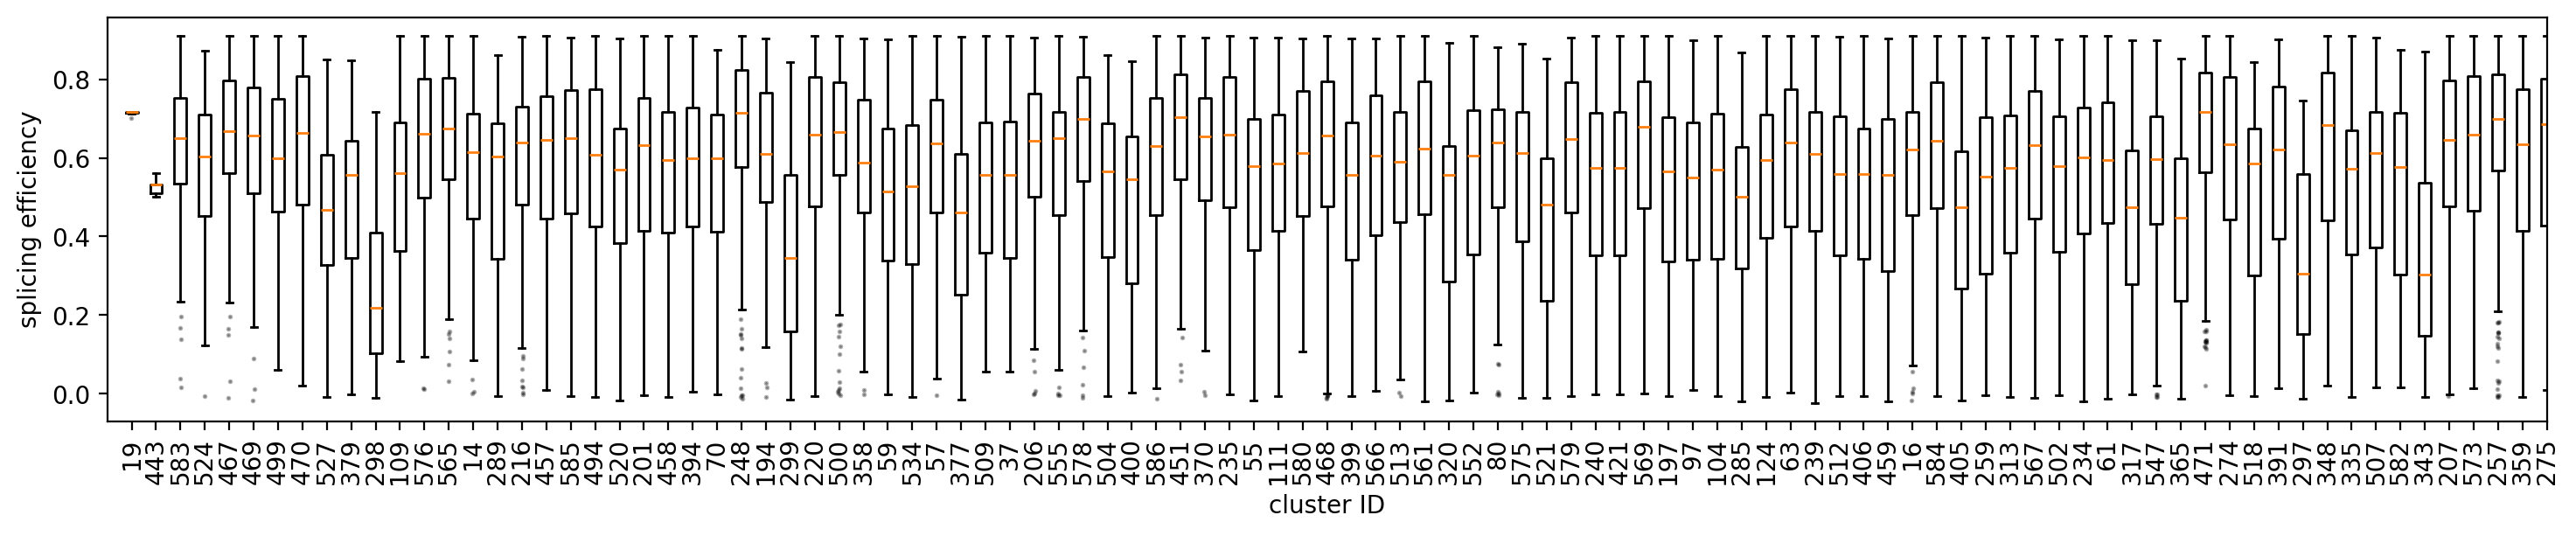

In [54]:
def flier_mask(x):
    x = x[np.isfinite(x)]
    iqr = abs(np.percentile(x, 75) - np.percentile(x, 25))
    flier_up = np.percentile(x, 75) + 1.5*iqr
    flier_dn = np.percentile(x, 25) - 1.5*iqr
    mask = (x > flier_up) | (x < flier_dn)
    return(mask)

def x_univar(n, spread=0.3):
    return(spread*(np.random.rand(n)-0.5))

fig, axs = plt.subplots(figsize=[18,3])

# sort clusters by standard deviation
clusters_split = [ran.sort_df['mu_est'].to_numpy()[labels==i] for i in set(labels)]
order_box = np.argsort([np.std(i) for i in clusters_split])

# bpxplot
axs.boxplot([clusters_split[i] for i in order_box], widths=0.5, showfliers=False)
axs.set_ylabel('splicing efficiency')
axs.set_xlabel('cluster ID')

for i, ds in enumerate([clusters_split[i] for i in order_box]):
    fliers = ds[flier_mask(ds)]
    axs.plot(np.repeat(i+1, len(fliers)) + x_univar(len(fliers), spread=0.1), fliers, '.k', alpha=0.3, ms=2)

axs.set_xticklabels(order_box+1, rotation=90)

axs.set_xlim([0, 100])
plt.show()

## Figure 2c

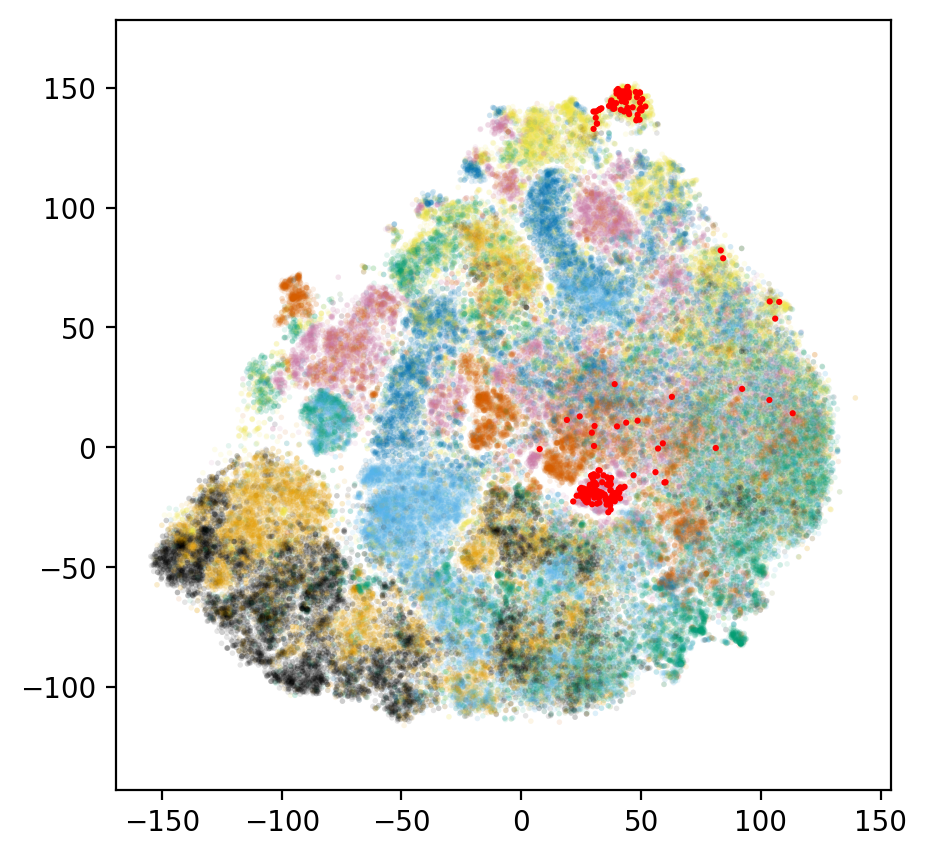

In [55]:
fig, axs = plt.subplots(figsize=[5,5])

axs.scatter(X_tsne_ent[:,0], X_tsne_ent[:,1], 4, labels, cmap=Colormap('okabeito').to_mpl(), alpha=0.1, edgecolors='none', rasterized=True)
axs.scatter(X_tsne_ent[:,0][labels==298], X_tsne_ent[:,1][labels==298], 5, 'r', edgecolors='none')
axs.scatter(X_tsne_ent[:,0][labels==583], X_tsne_ent[:,1][labels==583], 5, 'r', edgecolors='none')
axs.axis('equal')

plt.show()

## Figure 2d

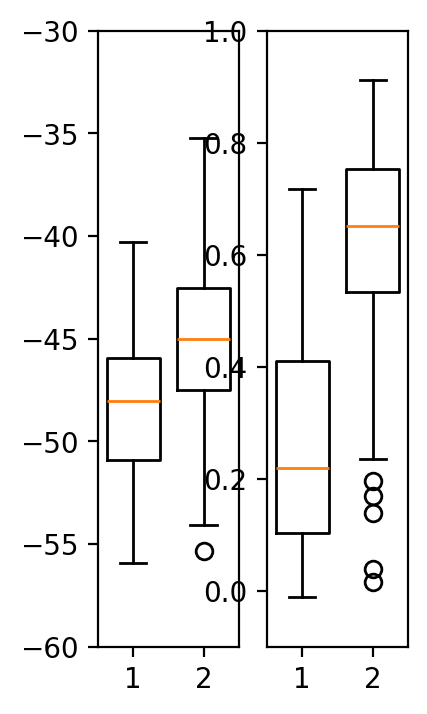

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=[2, 4])

axs[0].boxplot(efe[labels==298], positions=[1], widths=0.75)
axs[0].boxplot(efe[labels==583], positions=[2], widths=0.75)
axs[0].set_ylim([-60, -30])

axs[1].boxplot(ran.sort_df['mu_est'].filter(labels==298), positions=[1], widths=0.75)
axs[1].boxplot(ran.sort_df['mu_est'].filter(labels==583), positions=[2], widths=0.75)
axs[1].set_ylim([-0.1, 1])
plt.show()

## Figure 2e

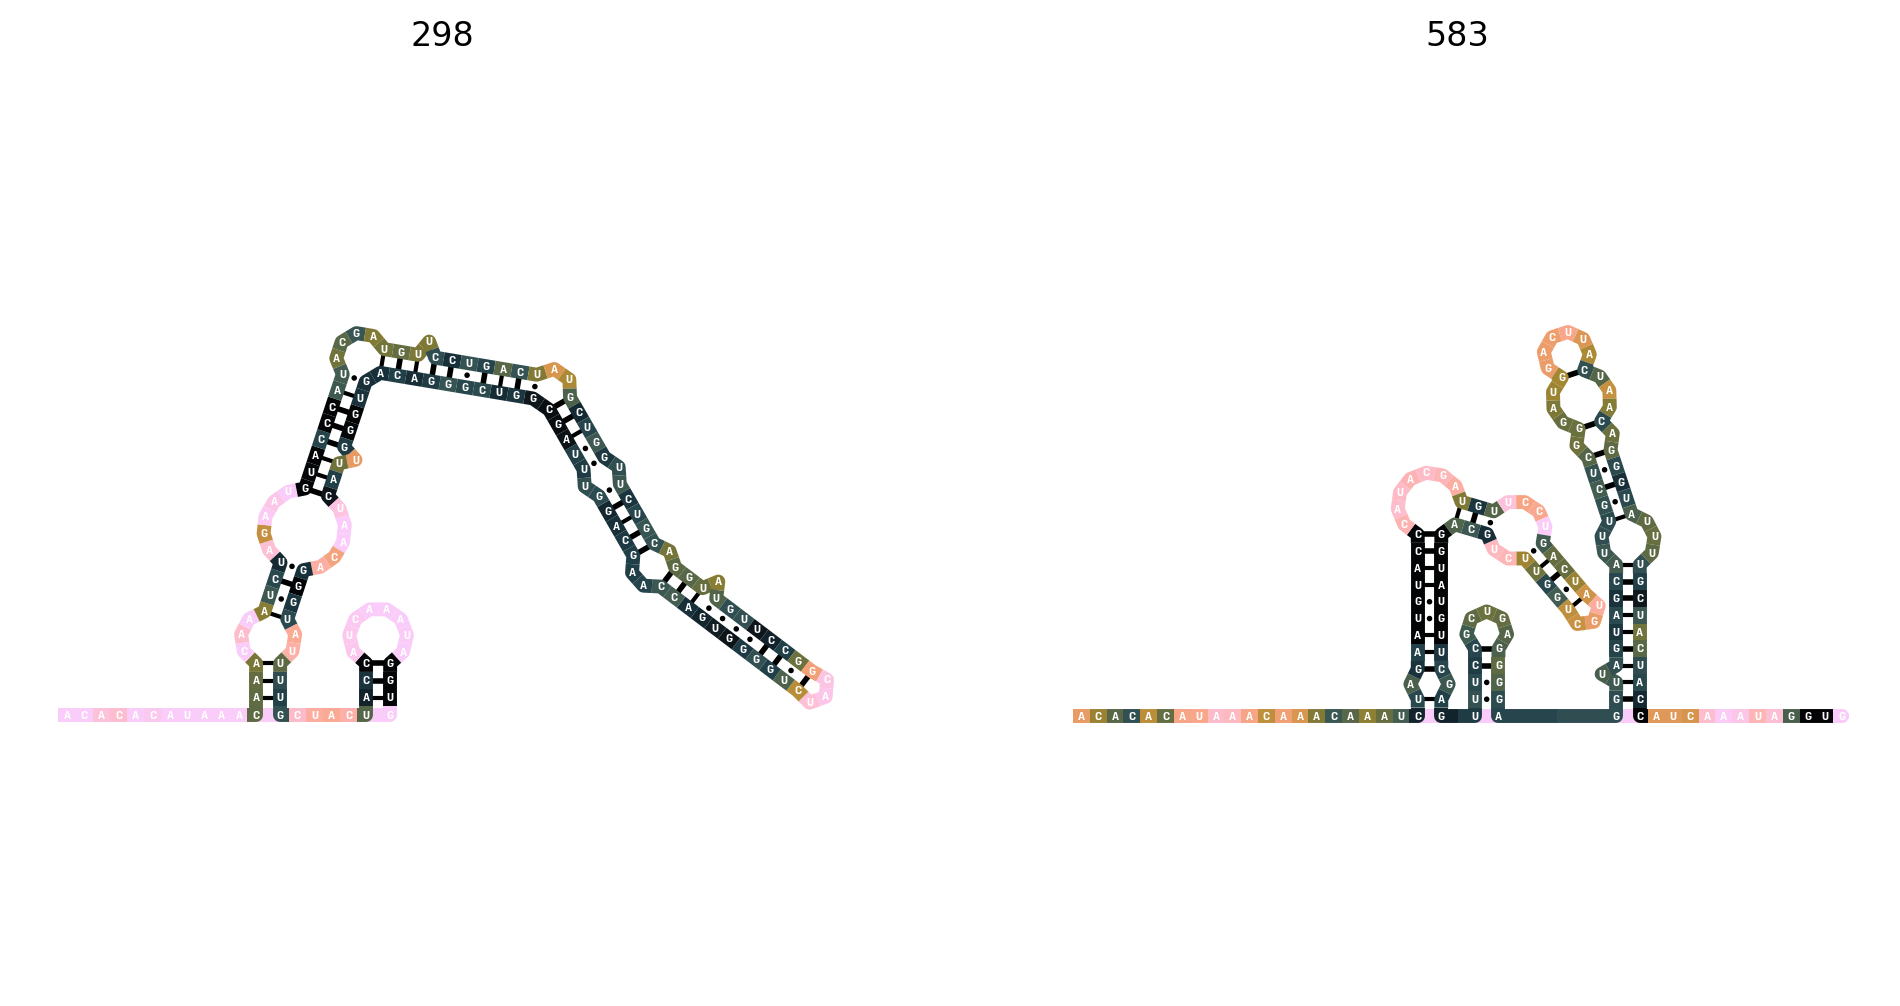

In [63]:
def auroc(x, y):  
    mwu = mannwhitneyu(x, y)
    u = mwu[0]
    n1, n2 = len(x), len(y)
    area = u/(n1*n2)
    return(area)

def score_dbr(y, dbr):
    unpaired_mask = np.array(list(dbr)) == '.'
    return(auroc(y[~unpaired_mask], y[unpaired_mask]))

def get_best_structure(avg_bpp, dbrs):
    idx_min = np.argmax([score_dbr(avg_bpp, dbr) for dbr in dbrs])
    return(idx_min)

fig, axs = plt.subplots(1, 2, figsize=[12, 6])
axs = axs.flatten()
cmap = Colormap('batlowk_r').to_mpl()
for idx, cluster_id in enumerate([298, 583]):

    avg_bpp  = np.mean(bpp[labels==cluster_id], axis=0)
    std_bpp  = np.std(bpp[labels==cluster_id], axis=0)
    idx_best = get_best_structure(avg_bpp, dbr_mfe[labels==cluster_id])
    dbr_best = dbr_mfe[labels==cluster_id][idx_best]
    dbr_best_filt = filter_dbr_by_dist(dbr_best, 150)
    
    plot_structure(np.array(pred_seqs)[labels==cluster_id][idx_best], dbr_best_filt, avg_bpp, np.array([True]*len(dbr_best)), axs=axs[idx], cmap=cmap, line_width=5, text_size=4, vmin=0.1, vmax=0.9)
    axs[idx].set_title(cluster_id)

plt.show()


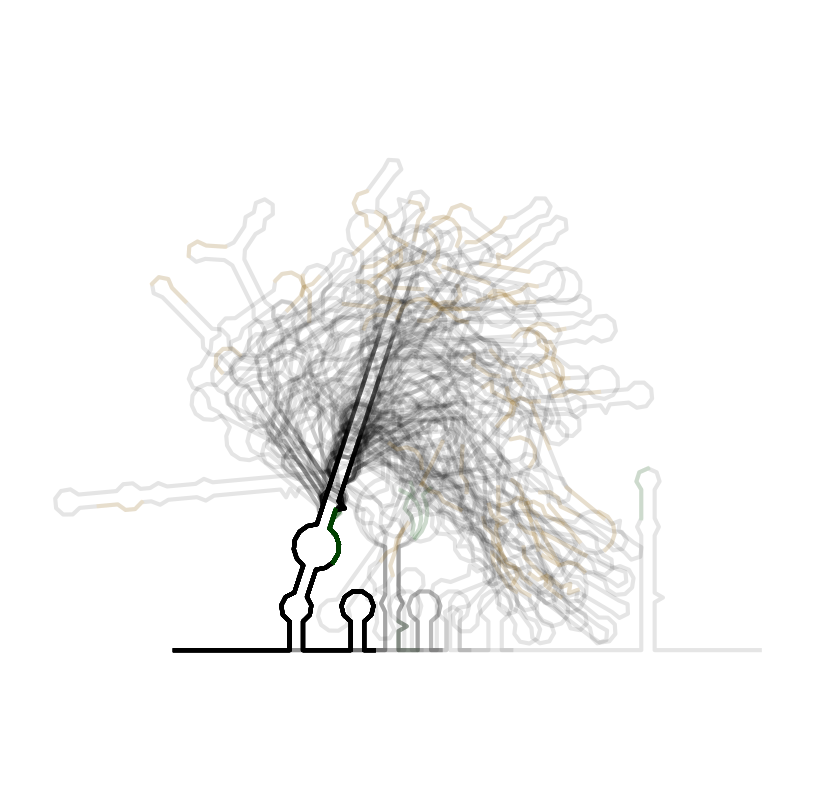

In [66]:
chosen_cluster = 298 # 583

chosen_mask = labels==chosen_cluster
n_axs = np.ceil(np.sqrt(np.sum(chosen_mask)))
fig, axs = plt.subplots(figsize=[5,5])
axs.axis('equal')
axs.axis('off')
cmap = Colormap('batlowk_r').to_mpl()
for i in range(np.sum(chosen_mask)):

    bpp_i = bpp[chosen_mask][i]
    efe_i = efe[chosen_mask][i]
    dbr_i = dbr_mfe[chosen_mask][i]
    seq_i = np.array(pred_seqs)[chosen_mask][i]
    
    dbr_i_filt = filter_dbr_by_dist(dbr_i, 150)
    coords_x, coords_y = get_coords(dbr_i_filt)
    axs.plot(coords_x, coords_y, '-k', alpha=0.1)
    axs.plot(coords_x[66:72], coords_y[66:72], '-', color='orange', alpha=0.1)
    axs.plot(coords_x[120:127], coords_y[120:127], '-', color='green', alpha=0.1)
plt.show()
